In [1]:
# Setting up a model and a mesh for the MT forward problem

<img src="./Poster/MTDiamonds-02.png">

In [2]:
import SimPEG as simpeg, sys
import numpy as np
from SimPEG import NSEM
sys.path.append('/Volumes/MacintoshHD/Users/thibautastic/Dropbox/PhD_UBC/telluricpy')
import telluricpy
import matplotlib.pyplot as plt
%matplotlib inline
import copy

/Applications/Anaconda/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<img src="./Poster/GeoModel.png">

In [3]:
# Define the area of interest
bw, be = 557100, 557580
bs, bn = 7133340, 7133960
bb, bt = 0,480

In [4]:
hSizeI,vSizeI =  25., 10.
nrCcoreI = [12, 6, 6, 6, 5, 4, 3, 2, 1]
hPadI = simpeg.Utils.meshTensor([(hSizeI,9,1.5)])
hxI = np.concatenate((hPadI[::-1],np.ones(((be-bw)/hSizeI,))*hSizeI,hPadI))
hyI = np.concatenate((hPadI[::-1],np.ones(((bn-bs)/hSizeI,))*hSizeI,hPadI))
airPadI = simpeg.Utils.meshTensor([(vSizeI,12,1.5)])
vCoreI = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcoreI,(simpeg.Utils.meshTensor([(vSizeI,1),(vSizeI,8,1.3)])))])[::-1]
botPadI = simpeg.Utils.meshTensor([(vCoreI[0],7,-1.5)])
hzI = np.concatenate((botPadI,vCoreI,airPadI))
# Calculate the x0 point
x0I = np.array([bw-np.sum(hPadI),bs-np.sum(hPadI),bt-np.sum(vCoreI)-np.sum(botPadI)])
# Make the mesh
meshInv = simpeg.Mesh.TensorMesh([hxI,hyI,hzI],x0I)

meshFor=copy.deepcopy(meshInv)

/Applications/Anaconda/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [9]:
print 'the number of cells:',meshFor.nC
print meshFor

the number of cells: 99456
  ---- 3-D TensorMesh ----  
   x0: 554291.75
   y0: 7130531.75
   z0: -4530.95
  nCx: 37
  nCy: 42
  nCz: 64
   hx: 961.08, 640.72, 427.15, 284.77, 189.84, 126.56, 84.38, 56.25, 37.50, 19*25.00, 37.50, 56.25, 84.38, 126.56, 189.84, 284.77, 427.15, 640.72, 961.08
   hy: 961.08, 640.72, 427.15, 284.77, 189.84, 126.56, 84.38, 56.25, 37.50, 24*25.00, 37.50, 56.25, 84.38, 126.56, 189.84, 284.77, 427.15, 640.72, 961.08
   hz: 1393.75, 929.17, 619.45, 412.96, 275.31, 183.54, 122.36, 81.57, 2*62.75, 3*48.27, 4*37.13, 5*28.56, 6*21.97, 6*16.90, 6*13.00, 12*10.00, 15.00, 22.50, 33.75, 50.62, 75.94, 113.91, 170.86, 256.29, 384.43, 576.65, 864.98, 1297.46


In [14]:
# Save the mesh and reload it in VTK
#meshFor.writeVTK('nsmesh_FineHKPK1.vtr',{'id':np.arange(meshFor.nC)})
nsvtr = telluricpy.vtkTools.io.readVTRFile('nsmesh_HPVK1_inv.vtr')

In [15]:
#Extract Topographie
topoSurf = telluricpy.vtkTools.polydata.normFilter(telluricpy.vtkTools.io.readVTPFile('../Geological_model/CDED_Lake_Coarse.vtp'))
activeMod = telluricpy.vtkTools.extraction.extractDataSetWithPolygon(nsvtr,topoSurf)

In [16]:
#telluricpy.vtkTools.io.writeVTUFile('activeModel.vtu',activeMod)

In [17]:
# Get active indieces 
activeInd = telluricpy.vtkTools.dataset.getDataArray(activeMod,'id')

In [19]:
# Make the conductivity dictionary
# Note: using the background value for the till, since the extraction gets the ind's below the till surface
geoStructFileDict = {'Till':1e-4,
 'PK1':5e-2,
 'HK1':1e-3,
  'VK':5e-3}

In [20]:
# Loop through
extP = '../Geological_model/'
geoStructIndDict = {}
for key, val in geoStructFileDict.iteritems():
    geoPoly = telluricpy.vtkTools.polydata.normFilter(telluricpy.vtkTools.io.readVTPFile(extP+key+'.vtp'))
    modStruct = telluricpy.vtkTools.extraction.extractDataSetWithPolygon(activeMod,geoPoly,extBoundaryCells=True,extInside=True,extractBounds=True)
    geoStructIndDict[key] = telluricpy.vtkTools.dataset.getDataArray(modStruct,'id')

In [21]:
# Make the physical prop
sigma = np.ones(meshFor.nC)*1e-8
sigma[activeInd] = 1e-3 # 1e-4 is the background and 1e-3 is the till value
# Add the structure
for key in ['Till','PK1','HK1','VK']:
    sigma[geoStructIndDict[key]] = geoStructFileDict[key]

<img src="./NSEMorignalModelPV.png">

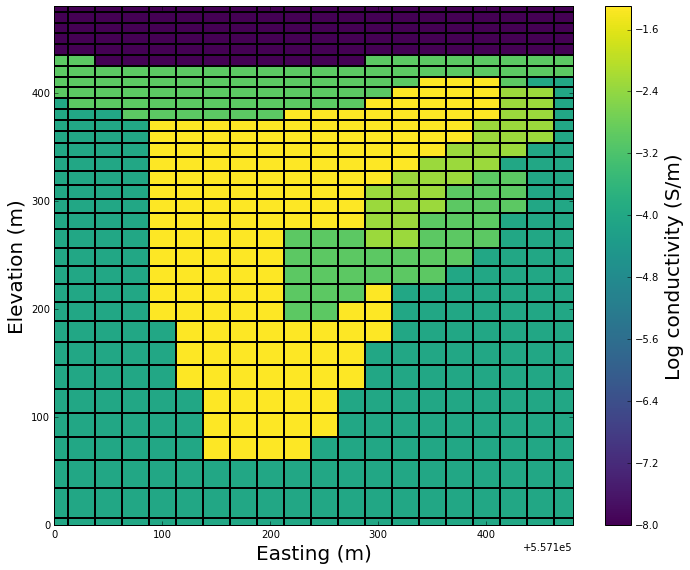

In [22]:
#Visualisation
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
model = sigma.reshape(meshFor.vnC,order='F')
a = ax.pcolormesh(meshFor.gridCC[:,0].reshape(meshFor.vnC,order='F')[:,20,:],meshFor.gridCC[:,2].reshape(meshFor.vnC,order='F')[:,20,:],np.log10(model[:,20,:]),edgecolor='k',cmap='viridis')

ax.set_xlim([bw,be])
ax.set_ylim([0,bt])
#ax.grid(which="major")
cb = plt.colorbar(a)
ax.set_aspect("equal")
cb.set_label("Log conductivity (S/m)",fontsize=20)
ax.set_xlabel("Easting (m)",fontsize=20)
ax.set_ylabel("Elevation (m)",fontsize=20)

plt.tight_layout()

In [23]:
# Save the model
#meshFor.writeVTK('nsmesh_FineHKPK1Fin.vtr',{'S/m':sigma})

In [39]:
# Set up the forward modeling
freq = np.logspace(5,2,16)
np.save('MTfrequencies',freq)

In [40]:
# Find the locations on the surface of the model.
# Get the outer shell of the model
import vtk
actModVTP = telluricpy.vtkTools.polydata.normFilter(telluricpy.vtkTools.extraction.geometryFilt(activeMod))
polyBox = vtk.vtkCubeSource()
polyBox.SetBounds(bw-5.,be+5,bs-5.,bn+5.,bb-5.,bt+5)
polyBox.Update()
# Exract the topo of the model
modTopoVTP = telluricpy.vtkTools.extraction.extractDataSetWithPolygon(actModVTP,telluricpy.vtkTools.polydata.normFilter(polyBox.GetOutput()),extractBounds=False)
telluricpy.vtkTools.io.writeVTPFile('topoSurf.vtp',actModVTP)

In [52]:
# Make the rxLocations file
x,y = np.meshgrid(np.arange(bw+10.,be,20),np.arange(bs+10.,bn,20))
xy = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))
# Find the location array
locArr = telluricpy.modelTools.surfaceIntersect.findZofXYOnPolydata(xy,actModVTP) #modTopoVTP)
np.save('MTlocations',locArr)

<img src="./Poster/MT_Data_Locations.png">

In [53]:
telluricpy.vtkTools.io.writeVTPFile('MTloc.vtp',telluricpy.dataFiles.XYZtools.makeCylinderPtsVTP(locArr,5,10,10))

In [60]:
# Running the forward modelling on the Cluster.
# Define the forward run in findDiam_MTforward.py

In [71]:
%matplotlib qt
sys.path.append('/home/gudni/Dropbox/code/python/MTview/')
import interactivePlotFunctions as iPf

In [72]:
# Load the data
mtData = np.load('MTdataStArr_nsmesh_HKPK1.npy')
mtData

array([ (100000.0, 557110.0, 7133350.0, 430.0, (-1.1506946677168877-1.2968733538942032j), (-23.54311070144429-19.772598506113592j), (23.122674523601596+16.553191376249956j), (0.9829648263716114+1.0160859204765444j), (-0.01149115639336881-0.08206248665420915j), (-0.0456173506763778-0.034164268293959334j)),
       (100000.0, 557130.0, 7133350.0, 430.0, (-0.7746917073255672-1.159486343238143j), (-22.964390132774177-20.1959003955084j), (21.4348641328774+16.38053800316572j), (0.6560327531217727+0.9550969901843831j), (-0.02089376870480284-0.06961905697131537j), (-0.053884654330991905-0.04363080750086569j)),
       (100000.0, 557150.0, 7133350.0, 430.0, (-0.6752011886313354-1.1676037152435292j), (-22.491532296418313-20.52581540138984j), (20.413657171072817+16.42466481134132j), (0.6638087171680884+1.0822899762152727j), (-0.026225671652060738-0.057567627605059984j), (-0.06032865752192971-0.05272531832396195j)),
       ...,
       (100.0, 557530.0, 7133950.0, 440.0, (0.44311335566511817+0.135906

In [110]:
iPf.MTinteractiveMap([mtData])

In [104]:
# Looking at the data shows that data below 100Hz is affected by the boundary conditions, 
# which makes sense for very conductive conditions as we have.
# Invert data in the 1e5-1e2 range.

Run the inversion on the cluster using the inv3d/run1/findDiam_inversion.py

In [106]:
drecAll = np.load('MTdataStArr_nsmesh_0.npy')

In [109]:
np.unique(drecAll['freq'])[10::]

array([    100.        ,     158.48931925,     251.18864315,
           398.10717055,     630.95734448,    1000.        ,
          1584.89319246,    2511.88643151,    3981.07170553,
          6309.5734448 ,   10000.        ,   15848.93192461,
         25118.8643151 ,   39810.71705535,   63095.73444802,  100000.        ])

In [93]:
# Build the Inversion mesh
# Design the tensors
hSizeI,vSizeI =  25., 10.
nrCcoreI = [12, 6, 6, 6, 5, 4, 3, 2, 1]
hPadI = simpeg.Utils.meshTensor([(hSizeI,9,1.5)])
hxI = np.concatenate((hPadI[::-1],np.ones(((be-bw)/hSizeI,))*hSizeI,hPadI))
hyI = np.concatenate((hPadI[::-1],np.ones(((bn-bs)/hSizeI,))*hSizeI,hPadI))
airPadI = simpeg.Utils.meshTensor([(vSizeI,12,1.5)])
vCoreI = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcoreI,(simpeg.Utils.meshTensor([(vSizeI,1),(vSizeI,8,1.3)])))])[::-1]
botPadI = simpeg.Utils.meshTensor([(vCoreI[0],7,-1.5)])
hzI = np.concatenate((botPadI,vCoreI,airPadI))
# Calculate the x0 point
x0I = np.array([bw-np.sum(hPadI),bs-np.sum(hPadI),bt-np.sum(vCoreI)-np.sum(botPadI)])
# Make the mesh
meshInv = simpeg.Mesh.TensorMesh([hxI,hyI,hzI],x0I)

In [94]:
meshInv.writeVTK('nsmesh_HPVK1_inv.vtr',{'id':np.arange(meshInv.nC)})

In [101]:
nsInvvtr = telluricpy.vtkTools.io.readVTRFile('nsmesh_HPVK1_inv.vtr')
activeModInv = telluricpy.vtkTools.extraction.extractDataSetWithPolygon(nsInvvtr,topoSurf,extBoundaryCells=True)

In [102]:
sigma = np.ones(meshInv.nC)*1e-8
indAct = telluricpy.vtkTools.dataset.getDataArray(activeModInv,'id')
sigma[indAct] = 1e-4

In [103]:
meshInv.writeVTK('nsmesh_HPVK1_inv.vtr',{'id':np.arange(meshInv.nC),'S/m':sigma})

In [108]:
from pymatsolver import MumpsSolver

ImportError: cannot import name MumpsSolver

In [106]:
pymatsolver.AvailableSolvers

{'DiagonalSolver': True,
 'Mumps': False,
 'TriangleFortran': False,
 'TrianglePython': True}

In [116]:
NSEM.Utils.skindepth(1000,100000)

50.329212104487041

In [117]:
np.unique(mtData['freq'])[5::]

array([   1000.        ,    1584.89319246,    2511.88643151,
          3981.07170553,    6309.5734448 ,   10000.        ,
         15848.93192461,   25118.8643151 ,   39810.71705535,
         63095.73444802,  100000.        ])